[*********************100%***********************]  1 of 1 completed
Max Drawdown:  -0.08356288503639342
CAGR:  0.5502221097394138


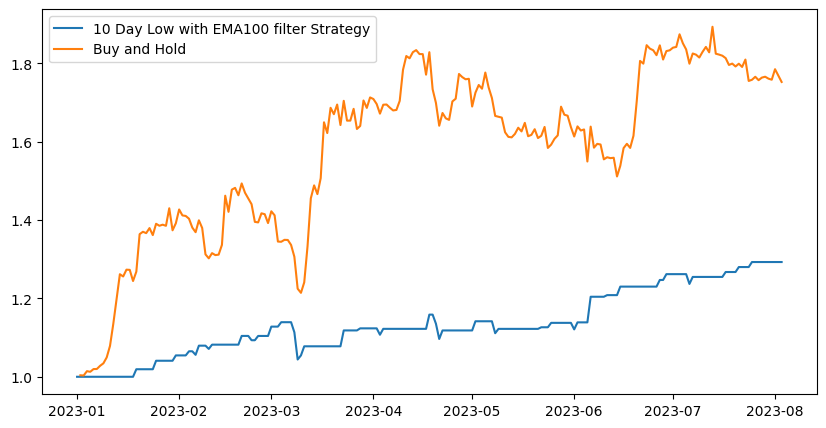

In [4]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

# Download historical data
data = yf.download('BTC-USD', start='2023-01-01')

# Calculate the 10-day low and EMA100
data['10_day_low'] = data['Low'].rolling(window=1).min()

# Create a signal when the close price drops below the 10_day_low and is above the EMA100
data['buy_signal'] = (data['Close'] < data['10_day_low'].shift())

# Create a column that contains the price at which we last bought
data['buy_price'] = np.where(data['buy_signal'], data['Close'], np.nan)
data['buy_price'].ffill(inplace=True)

# Create a signal when the high price reaches 4% above the buy price or we exit at the close price
data['take_profit_signal'] = np.where(data['High'] > data['buy_price'] * 1.01, 1, 0).astype(int)
# Sell the next day
data['sell_signal'] = data['buy_signal'].shift()

# Calculate daily percentage returns of strategy
data['strategy_returns'] = np.where(data['sell_signal'] == 1, np.where(data['take_profit_signal'] == 1, data['Close'].pct_change(), 0.01), 0)

# Calculate cumulative returns of strategy
data['strategy_cumulative_returns'] = (data['strategy_returns'] + 1).cumprod()

# Buy and Hold returns
data['buy_and_hold_returns'] = data['Close'].pct_change()

# Cumulative Buy and Hold returns
data['buy_and_hold_cumulative_returns'] = (data['buy_and_hold_returns'] + 1).cumprod()

# Calculate max drawdown
rolling_max = data['strategy_cumulative_returns'].cummax()
daily_drawdown = data['strategy_cumulative_returns']/rolling_max - 1.0
max_daily_drawdown = daily_drawdown.min()
print("Max Drawdown: ", max_daily_drawdown)

# Calculate CAGR
years = (data['strategy_cumulative_returns'].index[-1] - data['strategy_cumulative_returns'].index[0]).days / 365.25
cagr = (data['strategy_cumulative_returns'][-1])**(1/years) - 1
print("CAGR: ", cagr)

# Plot the equity curves of the strategy and the buy and hold
plt.figure(figsize=(10,5))
plt.plot(data['strategy_cumulative_returns'], label='10 Day Low with EMA100 filter Strategy')
plt.plot(data['buy_and_hold_cumulative_returns'], label='Buy and Hold')
plt.legend()
plt.show()